In [17]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [18]:
words = open('data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [19]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [20]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [21]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [22]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [23]:
for p in parameters:
  p.requires_grad = True

In [24]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [25]:
lri = []
lossi = []
stepi = []

In [26]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

In [27]:
# training loss 
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1138, grad_fn=<NllLossBackward0>)

In [28]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1618, grad_fn=<NllLossBackward0>)

In [29]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1549, grad_fn=<NllLossBackward0>)

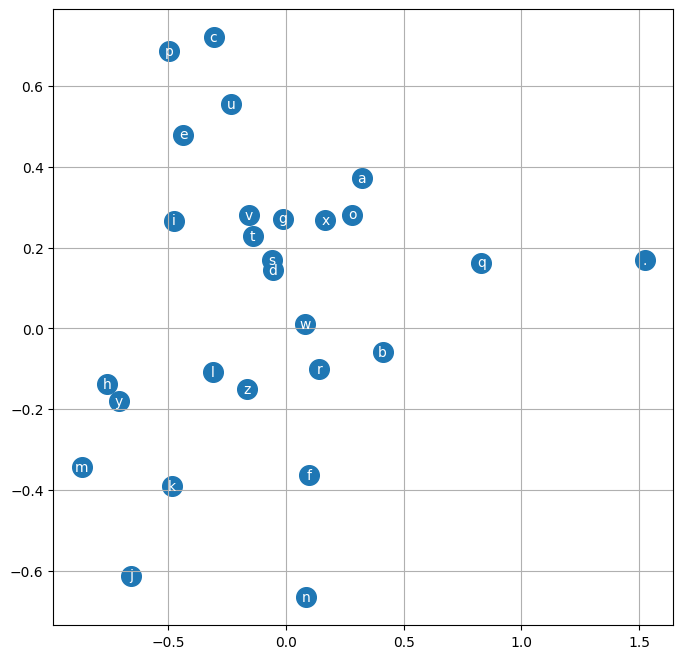

In [30]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [31]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carlah.
amille.
khi.
milia.
atlinnah.
sae.
rahnen.
deliah.
jareei.
nellara.
chaiiv.
kaleigh.
ham.
pori.
quinn.
shoil.
alianni.
wajehoniearynix.
kaelisselize.
deciia.


In [73]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt 

In [74]:
words = open('data/names.txt', 'r').read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [75]:
list_words = sorted(list(set(''.join(words))))

stoi =  {s:i+1 for i,s in enumerate(list_words)}
stoi['.'] = 0 
itos = {i:s for i , s in stoi.items()}
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [76]:
block_size = 3


# for w in words[:5]:

#     context = [0] * block_size
#     for ch in w + '.':
#         ix = stoi[ch]
#         X.append(context)
#         Y.append(ix)
#         context = context[1:] +[ix]



def build_dataset(words):
    X , Y = [], []
    for w in words:
        context = [0] *block_size
        for ch in w + '.':
            xi = stoi[ch]
            X.append(context)
            Y.append(xi)
            context = context[1:] + [xi]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y 

In [77]:
import random 
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

n1,n2

(25626, 28829)

In [78]:

print(f"train dataset - {n1}, validataion dataset - {n2-n1}")
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

train dataset - 25626, validataion dataset - 3203
torch.Size([182494, 3]) torch.Size([182494])
torch.Size([22822, 3]) torch.Size([22822])
torch.Size([22830, 3]) torch.Size([22830])


In [82]:

#model architecture 

block_size = 3
embedding_dim = 10
w1_neurons = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,embedding_dim  ),generator=g)
W1 = torch.randn((embedding_dim * block_size,w1_neurons),generator=g)
b1 = torch.randn(w1_neurons, generator=g)

W2 = torch.randn((w1_neurons,27), generator = g )
b2 = torch.randn(27,generator =g)

parameters = [C,W1, b1,W2,b2]

for p in parameters:
    p.requires_grad = True


#number of paramerters 
number_of_paramerters = sum(p.nelement() for p in parameters)
print(f"Number of paramerters: {number_of_paramerters}")


C.shape

Number of paramerters: 11897


torch.Size([27, 10])

In [102]:
for i in range(2000000):
    ix = torch.randint(0,Xtr.shape[0],(32,))

    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Ytr[ix])

    for p in parameters:
        p.grad = None 
    loss.backward()

    p.data += -0.1 * p.grad

print(loss)
    


tensor(20.5604, grad_fn=<NllLossBackward0>)


In [100]:
emb = C[Xtr]
emb.shape

h = torch.tanh(emb.view(-1,30)@W1+b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ytr)
loss

tensor(20.1949, grad_fn=<NllLossBackward0>)

In [101]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30)@ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(20.0578, grad_fn=<NllLossBackward0>)

In [99]:
emb = C[Xte]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(20.1945, grad_fn=<NllLossBackward0>)

In [ ]:
plt.figure(figsize = (8,8))
plt.scatter(C[:0].data,C[:,1])
